In [23]:
# Load the cleaned data

import pandas as pd

reviews = pd.read_csv('../data/cleaned_reviews.csv', parse_dates=["date"])

# Drop rows with missing values

reviews.dropna(inplace=True)

In [6]:
reviews.shape
print(reviews.head())

# Data types
print(reviews.dtypes)

# Info
print(reviews.info())

# Describe summary statistics
print(reviews.describe())

#Check for missing values
print(reviews.isna().sum())

                                              review  rating bank  \
0                         So bad now and hard to use       5  CBE   
1  it is so amazing app. but, it is better to upd...       5  CBE   
2                                         v.good app       4  CBE   
3                                      very good app       1  CBE   
4           Very amazing app indeed. I'm enjoying it       5  CBE   

        source       date                                   processed_review  
0  Google Play 2025-06-09                                       bad hard use  
1  Google Play 2025-06-09  amazing app better update access without inter...  
2  Google Play 2025-06-09                                                app  
3  Google Play 2025-06-09                                           good app  
4  Google Play 2025-06-08                        amazing app indeed enjoying  
review                      object
rating                       int64
bank                        object
source

In [24]:
# Sentiment analysis using Vader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to label sentiment
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply to each review
reviews['vader_sentiment'] = reviews['processed_review'].apply(get_vader_sentiment)

# Display sentiment distribution
print(reviews.groupby('bank')['vader_sentiment'].value_counts())

bank    vader_sentiment
BOA     positive           156
        neutral            128
        negative           114
CBE     positive           243
        neutral            106
        negative            37
Dashen  positive           285
        neutral             76
        negative            19
Name: count, dtype: int64


In [25]:
# Sentiment analysis using TextBlob

from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
reviews['textblob_sentiment'] = reviews['processed_review'].apply(get_sentiment)

# Display sentiment distribution
print(reviews.groupby('bank')['textblob_sentiment'].value_counts())

bank    textblob_sentiment
BOA     positive              159
        neutral               136
        negative              103
CBE     positive              238
        neutral               120
        negative               28
Dashen  positive              281
        neutral                72
        negative               27
Name: count, dtype: int64


In [ ]:
# Keyword Extraction with TF-Ireviews

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Your extra stop words
extra_stop_words = ['cbe', 'boa', 'dashen', 'app', 'application', 'apes', 'bank', 'also', 'ca', 'ethiopia', 'even', 'ever', 'every', 'everything', 'get', 'use', 'used', 'using', 'know', 'one']

# Combine with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(extra_stop_words))

# Initialize TF-IDF Vectorizer with your custom stop words
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=50)

# Fit and transform your review text
tfidf_matrix = vectorizer.fit_transform(reviews['processed_review'])

# Get the cleaned list of keywords
keywords = vectorizer.get_feature_names_out()
print("Top keywords:", keywords)


Top keywords: ['account' 'ahead' 'amazing' 'banking' 'best' 'better' 'convenient'
 'crash' 'customer' 'developer' 'digital' 'easy' 'excellent' 'experience'
 'fast' 'feature' 'fix' 'good' 'great' 'issue' 'like' 'love' 'make'
 'mobile' 'money' 'need' 'nice' 'option' 'payment' 'phone' 'really'
 'reliable' 'screenshot' 'secure' 'service' 'slow' 'smooth' 'step' 'super'
 'thank' 'time' 'transaction' 'transfer' 'try' 'update' 'user' 'work'
 'working' 'worst' 'wow']


In [29]:
# Filter positive and negative reviews
positive_reviews = reviews[reviews['vader_sentiment'] == 'positive']['processed_review']
negative_reviews = reviews[reviews['vader_sentiment'] == 'negative']['processed_review']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(stop_words=stop_words, max_features=10)
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(stop_words=stop_words, max_features=10)
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

Top Keywords in Positive Reviews: ['amazing' 'banking' 'best' 'easy' 'fast' 'feature' 'good' 'like' 'make'
 'super']
Top Keywords in Negative Reviews: ['bad' 'banking' 'crash' 'fix' 'mobile' 'service' 'time' 'transaction'
 'work' 'worst']


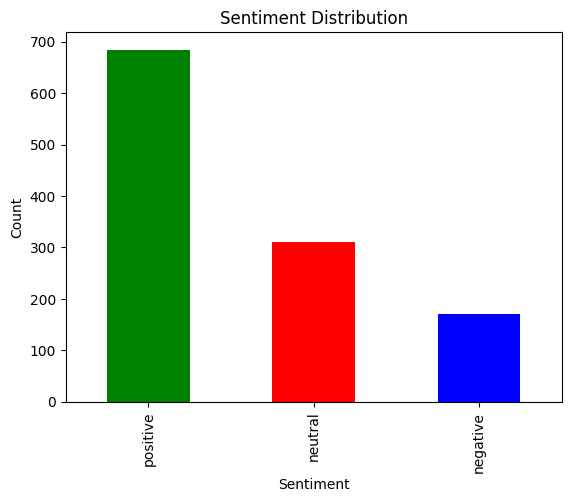

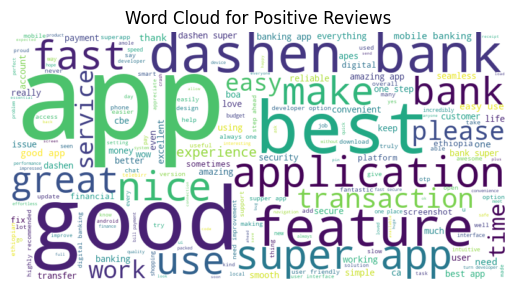

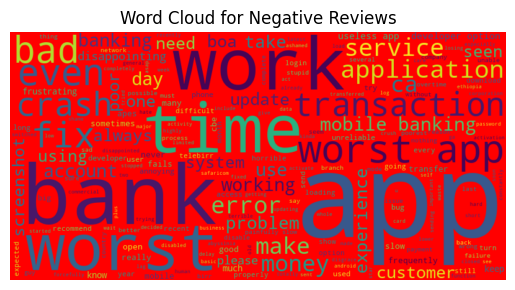

In [30]:
# Visualization

# Sentiment distribution
reviews['vader_sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word cloud for positive reviews
positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

negative_text = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='red').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()